In [ ]:
from preamble import *
%matplotlib inline

In [1]:
#from preamble import *
#%matplotlib inline
#=================================
from IPython.display import set_matplotlib_formats, display
import pandas as pd
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import mglearn
from cycler import cycler

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
plt.rc('axes', prop_cycle=( cycler('color', mglearn.plot_helpers.cm_cycle.colors) +  cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))


/var/folders/l_/499_8k_5387b9tz3wp5g8lg00000gn/T/ipykernel_6279/2603895367.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'png')


## Algorithm Chains and Pipelines

> There are standard workflows in applied machine learning. Standard because they overcome common problems like data leakage in your test harnes

- For many machine learning algorithms, the particular representation of the data that you provide is very important. This starts with scaling the data and combining features by hand and goes all the way to learning features using unsupervised machine learning. <br><br>
- Consequently, most machine learning applications require not only the application of a single algorithm, but the chaining together of many different processing steps and machine learning models. <br><br>
- In this chapter, we will cover how to use the **Pipeline** class to simplify the process of building chains of transformations and models. <br><br>
- In particular, we will see how we can combine Pipeline and GridSearchCV to search over parameters for all processing steps at once.

> Example: -  As an example of the importance of chaining models, we noticed that we can greatly improve the performance of a kernel SVM on the cancer dataset by using the Min MaxScaler for preprocessing. Here’s code for splitting the data, computing the minimum and maximum, scaling the data, and training the SVM:


In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [3]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


### Parameter Selection with Preprocessing 

- Now let’s say we want to find better parameters for SVC using GridSearchCV

- A naive approach might look like this:


In [4]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


### Probelm 


-  When scaling the data, we used all the data in the training set to find out how to train it. <br><br> 
-   We then use the scaled training data to run our grid search using cross-validation. <br><br> 
-   For each split in the cross-validation, some part of the original training set will be declared the training part of the split, and some the test part of the split.  <br><br> 
-   The test part is used to measure what new data will look like to a model trained on the training part.


> So, the splits in the cross-validation no longer correctly mirror how new data will look to the modeling process. We already leaked information from these parts of the data into our modeling process. This will lead to overly optimistic results during cross-validation, and possibly the selection of suboptimal parameters

> To get around this problem, the splitting of the dataset during cross-validation should be done before doing any preprocessing. Any process that extracts knowledge from the dataset should only ever be applied to the training portion of the dataset, so any cross-validation should be the “outermost loop” in your processing


Data leakage blog : https://towardsdatascience.com/how-to-avoid-data-leakage-while-evaluating-the-performance-of-a-machine-learning-model-ac30f2bb8586

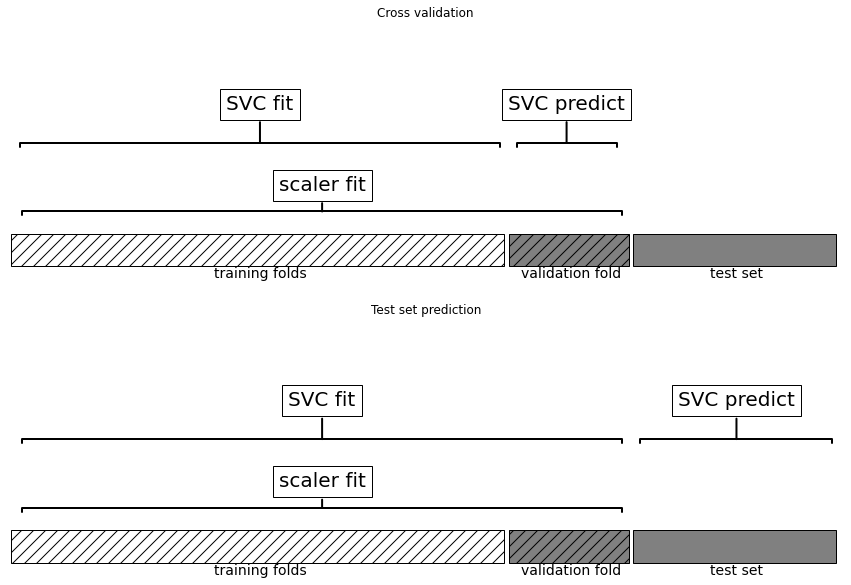

In [5]:
mglearn.plots.plot_improper_processing()

### What is the solution to Data Leakage?

- Sklearn pipeline  <br><br>
- Pipeline for k-fold cross-validation prevents data leakage and provides a better estimate of the model’s performance on unseen data. <br><br>
- The Pipeline class itself has fit, predict, and score methods and behaves just like any other model in scikit-learn.  <br><br>
- The most common use case of the Pipeline class is in chaining preprocessing steps (like scaling of the data) together with a supervised model like a classifier.

### Building Pipelines

-  The Pipeline class is a class that allows “gluing” together multiple processing steps into a single scikit-learn estimator <br><br>
-  Let’s look at how we can use the Pipeline class to express the workflow for training an SVM after scaling the data with MinMaxScaler (for now without the grid search). <br><br>
-  First, we build a pipeline object by providing it with a list of steps. Each step is a tuple containing a name (any string of your choosing1) and an instance of an estimator


In [48]:
#od approach
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


> **pipeline:** Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. See more from SKlearn [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)


In [7]:
# import the necessary modules
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# import pipeline from sklearn.pipeline  
from sklearn.pipeline import Pipeline


#Each step is a tuple containing a name (any string of your choosing1) and an instance of an estimator
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

#we created two steps: the first, called "scaler", is an instance of MinMaxScaler, and the second, called "svm", is an instance of SVC. Now, we can fit the pipeline, like any other scikit-learn estimator:
    
#pipe.fit first calls fit on the first step (the scaler), then transforms the training data using the scaler, and finally fits the SVM with the scaled data. To evaluate on the test data, we simply call pipe.score:

pipe.fit(X_train, y_train)

# score the pipeline on the test data
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


> Calling the score method on the pipeline first **transforms** the test data using the scaler, and then **calls the score method** on the SVM using the scaled test data. As you can see, the result is identical to the one we got above, when doing the transformations by hand. 


Using the pipeline, we reduced the code needed for our “preprocessing + classification” process. The main benefit of using the pipeline, however, is that we can now use this single estimator in cross_val_score or GridSearchCV

### Using Pipelines in Grid-searches

- Using a pipeline in a grid search works the same way as using any other estimator. We define a parameter grid to search over, and construct a GridSearchCV from the pipeline and the parameter grid 
- When specifying the parameter grid, there is a slight change, though. We need to specify for each parameter which step of the pipeline it belongs to. 
- Both parameters that we want to adjust, C and gamma, are parameters of SVC, the second step. We gave this step the name "svm". 
- The syntax to define a parameter grid for a pipeline is to specify for each parameter the step name, followed by __ (a double underscore), followed by the parameter name. To search over the C parameter of SVC we therefore have to use "svm__C" as the key in the parameter grid dictionary, and similarly for gamma:


In [8]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])


param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


> In contrast to the grid search we did before, now for each split in the cross-validation, the MinMaxScaler is refit with only the training splits and no information is leaked from the test split into the parameter search.


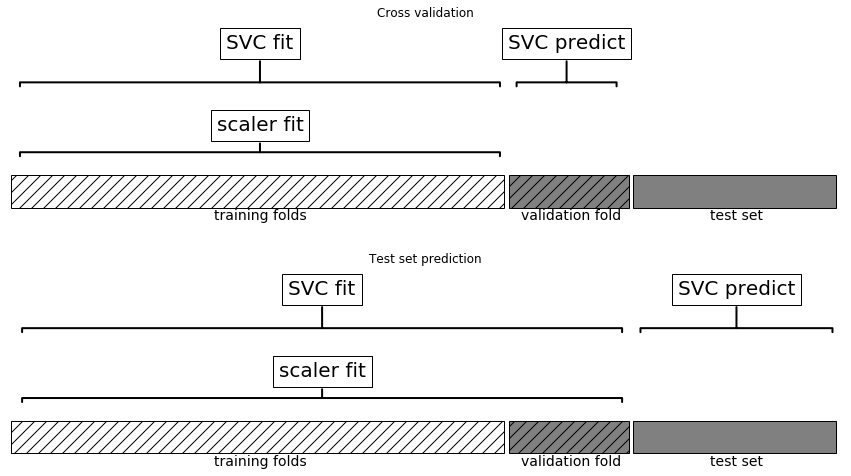

In [11]:
mglearn.plots.plot_proper_processing()

### Illustrating Information Leakage


> Let’s consider a synthetic regression task with 100 samples and 1,000 features that are sampled independently from a Gaussian distribution. We also sample the response from a Gaussian distribution:


In [9]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000)) #features
y = rnd.normal(size=(100,)) #target

> Given the way we created the dataset, there is no relation between the data, X, and the target, y (they are independent), so it should not be possible to learn anything from this dataset. <br><br>
 

We will select the most informative of the features using SelectPercentile feature selection, and then we evaluate a Ridge regressor using cross-validation:


In [11]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


> The mean Rsquared computed by cross-validation is 0.91, indicating a very good model. This clearly cannot be right, as our data is entirely random. What happened here is that our feature selection picked out some features among the 10,000 random features that are (by chance) very well correlated with the target. Because we fit the feature selection outside of the cross-validation, it could find features that are correlated both on the training and the test folds. The information we leaked from the test folds was very informative, leading to highly unrealistic results.

 Let’s compare this to a proper cross-validation using a pipeline:

In [14]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


> This time, we get a negative Rsquared score, indicating a very poor model.


### The General Pipeline Interface

> The Pipeline class is not restricted to preprocessing, it can join any number of estimators together.  <br><br>
> For example, you could build a pipeline containing feature extraction, feature selection, scaling, and classification, for a total of four steps. Similarly, the last step could be regression or clustering instead of classification


- The only requirement for estimators in a pipeline is that all but the last step need to have a transform method, so they can produce a new representation of the data that can be used in the next step <br><br>

- Pipeline.fit, the pipeline calls fit and then transform on each step in turn,2 with the input given by the output of the transform method of the previous step.



In [16]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [17]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # predict using the last step
    return self.steps[-1][1].predict(X_transformed)

![pipeline_illustration](images/pipeline.png)

### Convenient Pipeline creation with ``make_pipeline``

- Creating a pipeline using the syntax described earlier is sometimes a bit cumbersome, and we often don’t need user-specified names for each step. <br><br>
- There is a convenience function, make_pipeline, that will create a pipeline for us and automatically name each step based on its class. The syntax for make_pipeline is as follows:


In [15]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

> The pipeline objects pipe_long and pipe_short do exactly the same thing, but pipe_short has steps that were automatically named. We can see the names of the steps by looking at the steps attribute


In [16]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


> The steps are named minmaxscaler and svc. In general, the step names are just lowercase versions of the class names. If multiple steps have the same class, a number is appended:


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


> As you can see, the first StandardScaler step was named standardscaler-1 and the second standardscaler-2. However, in such settings it might be better to use the Pipeline construction with explicit names, to give more semantic names to each step


#### Accessing step attributes

> Often you will want to inspect attributes of one of the steps of the pipeline—say, the coefficients of a linear model or the components extracted by PCA. The easiest way to access the steps in a pipeline is via the named_steps attribute, which is a dictionary from the step names to the estimators:


In [18]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


#### Accessing Attributes in a Pipeline inside GridSearchCV

- One of the main reasons to use pipelines is for doing grid searches. <br><br>
- A common task is to access some of the steps of a pipeline inside a grid search. <br><br>
-  Let’s grid search a LogisticRegression classifier on the cancer dataset  <br><br>


In [21]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

- Lets us create a parameter grid. Regularization parameter to tune for LogisticRegression is the parameter C

In [27]:
#Because we used the make_pipeline function, the name of the LogisticRegression step in the pipeline is the lowercased class name, logisticregression. To tune the parameter C, we therefore have to specify a parameter grid for logisticregression__C:

param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

As usual, we split the cancer dataset into training and test sets, and fit a grid search:


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

So how do we access the coefficients of the best LogisticRegression model that was found by GridSearchCV?


In [26]:
#best model found by GridSearchCV, trained on all the training data, is stored in grid.best_estimator_:

print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


This best_estimator_ in our case is a pipeline with two steps, standardscaler and logisticregression. 


To access the logisticregression step, we can use the named_steps attribute of the pipeline, as explained earlier:


In [28]:
print("Logistic regression step:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1, max_iter=1000)


we can also access the coefficients (weights) associated with each input feature


In [29]:
print("Logistic regression coefficients:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


### Grid-searching preprocessing steps and model parameters

- Using pipelines, we can encapsulate all the processing steps in our machine learning workflow in a single scikit-learn estimaton <br><br>

- nother benefit of doing this is that we can now adjust the parameters of the preprocessing using the outcome of a supervised task like regression or classification. <br><br>
 

- In previous chapters, we used polynomial features on the boston dataset before applying the ridge regressor.  <br><br>
- Let’s model that using a pipeline instead. The pipeline contains three steps—scaling the data, computing polynomial features, and ridge regression:


In [31]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

> How do we know which degrees of polynomials to choose, or whether to choose any polynomials or interactions at all? Ideally we want to select the degree parameter based on the outcome of the classification. Using our pipeline, we can search over the degree parameter together with the parameter alpha of Ridge. To do this, we define a param_grid that contains both, appropriately prefixed by the step names:


In [33]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [34]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

We can visualize the outcome of the cross-validation using a heat map 


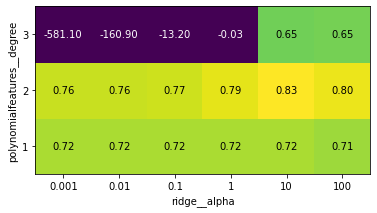

In [35]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

Looking at the results produced by the cross-validation, we can see that using polynomials of degree two helps, but that degree-three polynomials are much worse than either degree one or two. This is reflected in the best parameters that were found:


In [36]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [37]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


Let’s run a grid search without polynomial features for comparison:


In [38]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


### Grid-Searching Which Model To Use


- We can search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully <br><br>

- However, here is an example comparing a RandomForest Classifier and an SVC on the iris dataset. <br><br>
- We know that the SVC might need the data to be scaled, so we also search over whether to use StandardScaler or no preprocessing. <br><br>
- For the RandomForestClassifier, we know that no preprocessing is necessary. 


- We start by defining the pipeline. Here, we explicitly name the steps. We want two steps, one for the preprocessing and then a classifier. We can instantiate this using SVC and StandardScaler


In [40]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

- Now we can define the parameter_grid to search over. We want the classifier to be either RandomForestClassifier or SVC. 
- Because they have different parameters to tune, and need different preprocessing, we can make use of the list of search grids we discussed in “Search over spaces that are not grids” on page 271. 
- To assign an estimator to a step, we use the name of the step as the parameter name. When we wanted to skip a step in the pipeline (for example, because we don’t need preprocessing for the RandomForest, we can set that step to None:


In [43]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

Now we can instantiate and run the grid search as usual, here on the cancer dataset:


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.98


> The outcome of the grid search is that SVC with StandardScaler preprocessing, C=10, and gamma=0.01 gave the best result.


#### Avoiding Redundant Computation

The transformers in the pipeline can be cached using memory argument. Caching the transformers is advantageous when fitting is time consuming.

In [47]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")

### Summary and Outlook

- we introduced the Pipeline class, a general-purpose tool to chain together multiple processing steps in a machine learning workflow <br><br>

- Using pipelines allows us to encapsulate multiple steps into a single Python object that adheres to the familiar scikit-learn interface of fit, predict, and transform. <br><br>

- The Pipeline class also allows writing more succinct code, and reduces the likelihood of mistakes that can happen when building processing chains without the pipeline class (like forgetting to apply all transformers on the test set, or not applying them in the right order). <br><br>

- Choosing the right combination of feature extraction, preprocessing, and models is somewhat of an art, and often requires some trial and error. However, using pipelines, this “trying out” of many different processing steps is quite simple. <br><br>

- You now possess all the required skills and know the necessary mechanisms to apply machine learning in practice. In the next chapter, we will dive in more detail into one particular type of data that is commonly seen in practice, and that requires some special expertise to handle correctly: text data. <br><br>
